In [1]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
import ipywidgets as ipyw
import seaborn as sns
import pandas as pd
import SFG2D
import gui

from IPython.display import display
from watchdog.observers import Observer

# Set plot layout
plt.style.use('seaborn-notebook')
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

# Setup Data and Widget class
ppdData = gui.PumpProbeDashboardData('/home/malte/MeasurmentData/2016/08/01/')
ppWidget = gui.PumpProbeWidget(ppdData)
ppWidget.linkTraitlets()
#ppWidget.setupObservers(ppdData)

# Setup file observer
ffolder_observer = Observer()
event_handler = gui.MyHandler()
event_handler.ppdData = ppdData
event_handler.ppWidget = ppWidget
ffolder_observer.schedule(event_handler, ppdData.ffolder, recursive=False)
ffolder_observer.start()

## IR Profile

/home/malte/Analysis/SFG2D/io/veronica.py:261: UserWarning: cant determine spectrum type of data by filename.Trying to determine datatype from content.This is much slower
  warnings.warn('cant determine spectrum type of data by filename.'


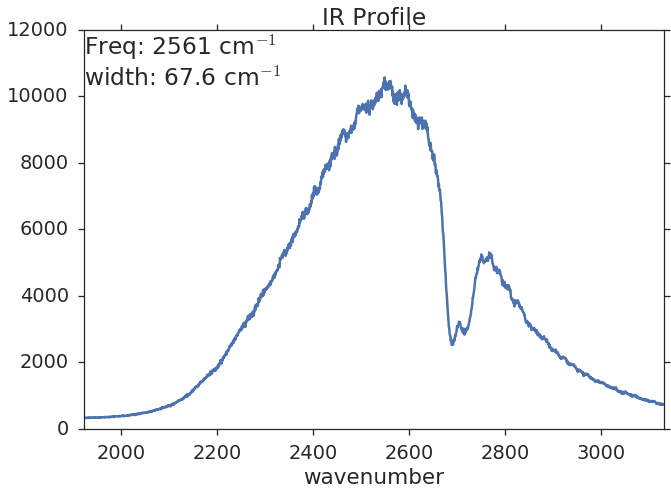

In [2]:
def set_ir(fpath, fbase, sub_base, spec):
    """ Dialogue used to set the ir spectrum """
    ppdData.ir = fpath
    ppdData.ir.base = SFG2D.io.veronica.read_auto(ppdData.ffolder + fbase).med
    if sub_base:
        ppdData.ir.sub_base(inplace=True)
    if spec is "All":
        ppdData.ir.df.plot()
    else:
        ppdData.ir.med[spec].plot()
        ppdData.ir.spec = spec
        s = r"Freq: %i cm$^{-1}$"%ppdData.ir.freq
        s += "\n"
        s += "width: %.3g cm$^{-1}$"%ppdData.ir.width
        plt.text(
            0, 1, s,
            horizontalalignment='left',
            verticalalignment='top',
            transform=plt.gca().transAxes
        )
    plt.title("IR Profile")
    plt.draw()

ppWidget.ir = ipyw.interactive(set_ir, fpath=ppWidget.ir_fpath, fbase=ppWidget.ir_fbase, 
                        sub_base=ppWidget.ir_sub_base, spec=ppWidget.ir_spec )
display(ppWidget.ir)
plt.show()

## Pump Profile

In [13]:
def set_pump(fpath):
    ppdData.pump = fpath
    isinstance(ppdData.pump.pp_delays, pd.indexes.numeric.Int64Index)
    ppWidget.pump_ppdelay.options = list(ppdData.pump.pp_delays)

def pump_plot(spec, pp_delay):
    ax=ax_pump.clear()
    s = r"Freq: %i cm$^{-1}$"%ppdData.pump.freq
    s += "\n"
    s += "width: %.3g cm$^{-1}$"%ppdData.pump.width
    plt.text(
        0, 1, s,
        horizontalalignment='left',
        verticalalignment='top',
        transform=plt.gca().transAxes
    )
    if isinstance(ppdData.pump.pp_delays, pd.indexes.numeric.Int64Index):
        ppdData.pump._pp_delay_pos = pp_delay

        if spec == "All":
            ppdData.pump.med.ix[pp_delay].plot(ax=ax_pump)
        else:
            ppdData.pump.med.ix[pp_delay, spec].plot(ax=ax_pump)
        plt.title('%i fs'%pp_delay)

    if isinstance(ppdData.pump.pp_delays, int):
        if spec == "All":
            ppdData.pump.med.plot(ax=ax_pump)
        else:
            ppdData.pump.med[spec].plot(ax=ax_pump)
        #plt.title('%i fs'%pp_delay)
    plt.draw()

def pump_plot_update(change):
    pump_plot(ppWidget.pump_spec.value, 
              ppWidget.pump_ppdelay.value) 

ppWidget.pump_fpath.observe(pump_plot_update, names='value')

ax:  Axes(0.125,0.125;0.775x0.775)


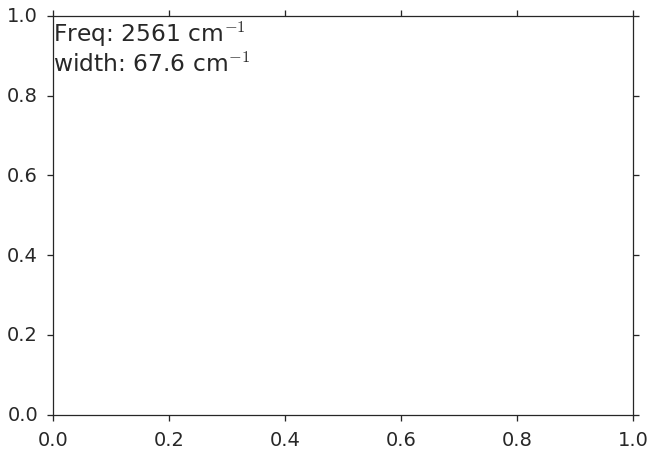

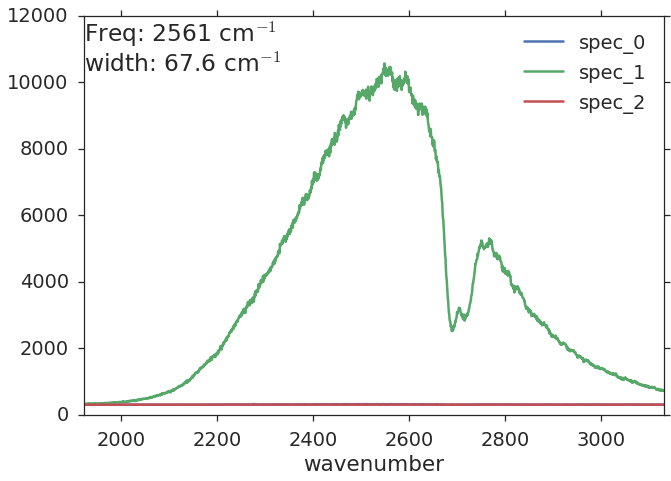

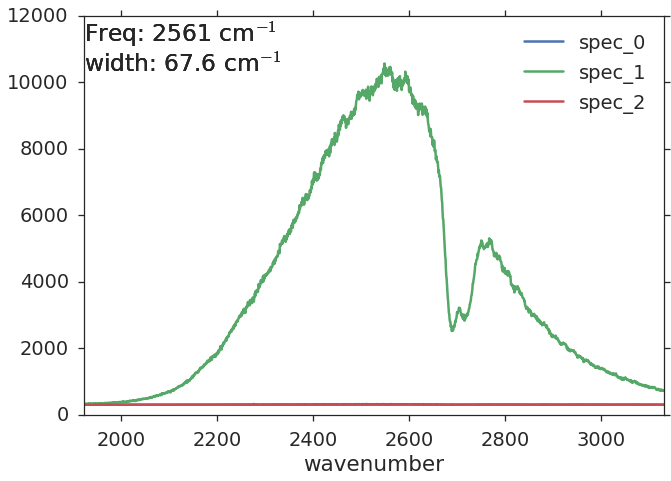

In [14]:
fig_pump, ax_pump = plt.subplots(1,1)
ppWidget.pump = ipyw.interactive(set_pump, fpath = ppWidget.pump_fpath)
display(ppWidget.pump)

ppWidget.pump_plot = ipyw.interactive(pump_plot, spec=ppWidget.pump_spec, pp_delay=ppWidget.pump_ppdelay)
display(ppWidget.pump_plot)

# Pump-Probe Data

## Baseline for Pump-Probe Data

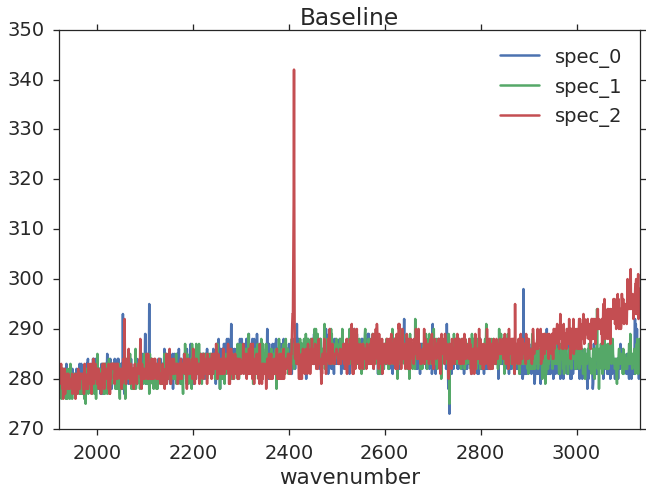

In [5]:
def set_base(fbase):
    ppdData.base = fbase
    ppdData.base.med.plot()
    plt.title("Baseline")
    plt.draw()

w_base = ipyw.interactive(set_base, fbase = ppWidget.fbase)
display(w_base)
plt.show()

In [6]:
def set_pump_probe(fpath, sub_base=False, normalize=False):
    ppdData.ts0 = SFG2D.io.veronica.read_auto(ppdData.ffolder + fpath)
    if sub_base:
        ppdData.ts0.base = ppdData.base.med
        ppdData.ts0.sub_base(inplace=True)
    if ppWidget.ir_spec.value is "All":
        ppdData.ts0.norm = ppdData.ir.med
    else:
        ppdData.ts0.norm = ppdData.ir.med[ppWidget.ir_spec.value]
    ppdData.ts0u = ppdData.ts0.__deepcopy__()
    if normalize:
        ppdData.ts0.normalize(inplace=True)
    ppWidget.ts0_ppdelay.options = list(ppdData.ts0.pp_delays)
    ppWidget.ts0_ppdelay.value=0
    
def ts0_pump_update(*args):
    #global ts0
    ppdData.ts0.pumped = ppWidget.ts0_pumped.value
    ppdData.ts0u.pumped = ppWidget.ts0_pumped.value
    
def ts0_probe_update(*args):
    #global ts0
    ppdData.ts0u.probed = ppWidget.ts0_probed.value
    ppdData.ts0.probed = ppWidget.ts0_probed.value
    
def pump_probe_sum_plot(*args):
    ax = axes_pump_probe_get[1]
    if isinstance(ppdData.ts0u, SFG2D.core.scan.TimeScan):
        [SFG2D.plotting.ts.sum_of_spectra(ppdData.ts0u, spec, ax) for spec in ('spec_0', 'spec_1', 'spec_2')]
    ax.set_title("Sum of Spectra")

def pump_probe_plot(pp_delay):
    ax = axes_pump_probe_get[0]
    ax.clear()
    
    if isinstance(ppdData.ts0u, SFG2D.core.scan.TimeScan):
        ppdData.ts0u.med.ix[pp_delay].plot(ax=ax)
        ax.set_title("%i fs"%pp_delay)
        #plt.ylim(-0.002, 0.015) # get this from set_pump_probedata
        #plt.xlim(2100, 2800) # get this from ir profile
    fig_pump_probe_get.tight_layout()
    display(fig_pump_probe_get)

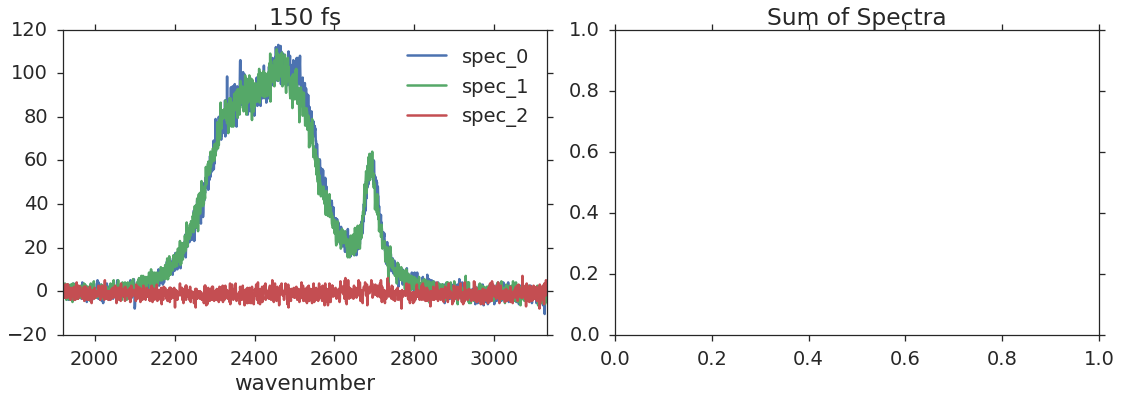

In [7]:
fig_pump_probe_get, axes_pump_probe_get = plt.subplots(1,2, figsize=(16,6))

ppWidget.ts0 = ipyw.interactive(set_pump_probe, fpath=ppWidget.ts0_fpath, sub_base=ppWidget.ts0_sub_base, normalize=ppWidget.ts0_normalize)
ppWidget.ts0_pumped.observe(ts0_pump_update, 'value')
ppWidget.ts0_probed.observe(ts0_probe_update, 'value')
pp


ppWidget.ts0_plot = ipyw.interactive(pump_probe_plot, pp_delay=ppWidget.ts0_ppdelay)
display(ppWidget.ts0, ppWidget.ts0_pumped, ppWidget.ts0_probed, ppWidget.ts0_plot)
pump_probe_sum_plot()

## Normalize Spectra

In [6]:
%%capture
fig_norm, ax_norm = plt.subplots(1,2, figsize=(12,6))
ax_norm[0].set_title("Unnormalized")
ax_norm[1].set_title("Normalized")
#ax_norm[1].set_ylim(-0.002, 0.015)
ppdData.ts0u.pumped.ix[ppWidget.ts0_ppdelay.value].plot(ax = ax_norm[0], label="pumped")
ppdData.ts0u.probed.ix[ppWidget.ts0_ppdelay.value].plot(ax = ax_norm[0], label="probed")

ppdData.ts0.pumped.ix[ppWidget.ts0_ppdelay.value].plot(ax = ax_norm[1], label = "pumped")
ppdData.ts0.probed.ix[ppWidget.ts0_ppdelay.value].plot(ax = ax_norm[1], label = "probed")

ax_norm[0].legend()
fig_norm.tight_layout()


def plot_norm_update(pp_delay):
    ax_norm[0].lines[0].set_ydata(ppdData.ts0u.pumped.ix[pp_delay])
    ax_norm[0].lines[1].set_ydata(ppdData.ts0u.probed.ix[pp_delay])

    ax_norm[1].lines[0].set_ydata(ppdData.ts0.pumped.ix[pp_delay])
    ax_norm[1].lines[1].set_ydata(ppdData.ts0.probed.ix[pp_delay])
       
    display(fig_norm)

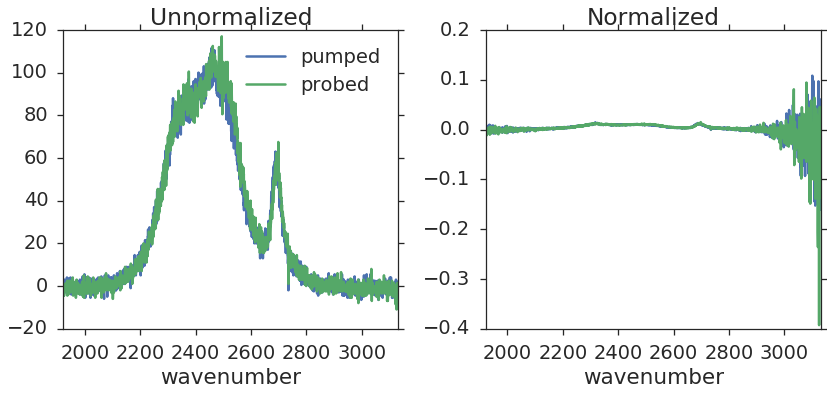

In [7]:
ipyw.interact(plot_norm_update, pp_delay=ppWidget.ts0_ppdelay_childs[0])

# Spectra Over Time

In [8]:
%%capture
roi = slice(2200,2800)

def plot_compare_update(pp_delay):
    for i in range(ppdData.ts0.df['spec_0'].shape[1]):
        data = ppdData.ts0.df.loc[ppWidget.ts0_ppdelay_childs[1].value, "spec_0"][roi].iloc[:,i]
        ax_compare[0].lines[i].set_ydata(data)
        data = ppdData.ts0.df.loc[ppWidget.ts0_ppdelay_childs[1].value, "spec_1"][roi].iloc[:,i]
        ax_compare[1].lines[i].set_ydata(data)
    
    display(fig_compare)
    

fig_compare, ax_compare = plt.subplots(1, 2, sharey=True, figsize=(16,6))
ppdData.ts0.df.loc[ppWidget.ts0_ppdelay_childs[1].value, "spec_0"][roi].plot(ax=ax_compare[0])        
ppdData.ts0.df.loc[ppWidget.ts0_ppdelay_childs[1].value, "spec_1"][roi].plot(ax=ax_compare[1])
for ax, title in zip(ax_compare, ('spec_0', 'spec_1')):
    ax.set_title(title)
    for i in range(len(ax.lines)):
        ax.lines[i].set_label('run %i'%i)
    ax.legend()
#plt.ylim(-0.002, 0.017)

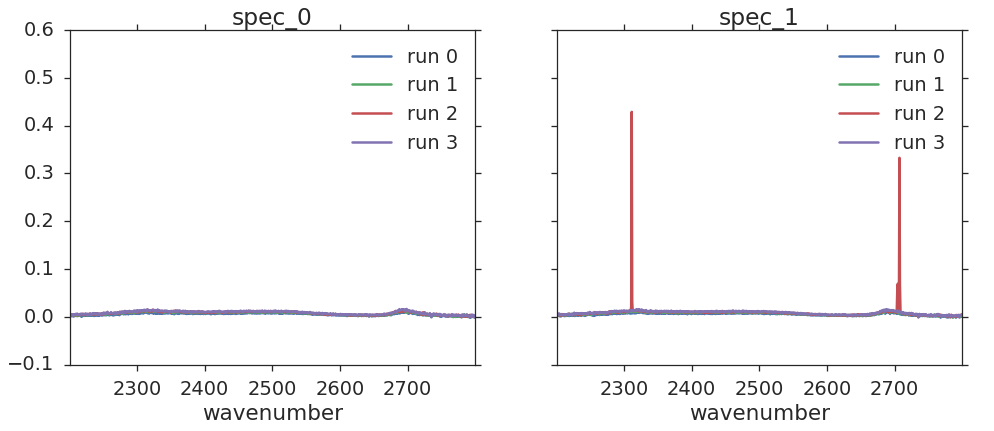

In [9]:
w_f0 = ipyw.interact(plot_compare_update, pp_delay=ppWidget.ts0_ppdelay_childs[1])
#display(w_f0)

## Smoothed

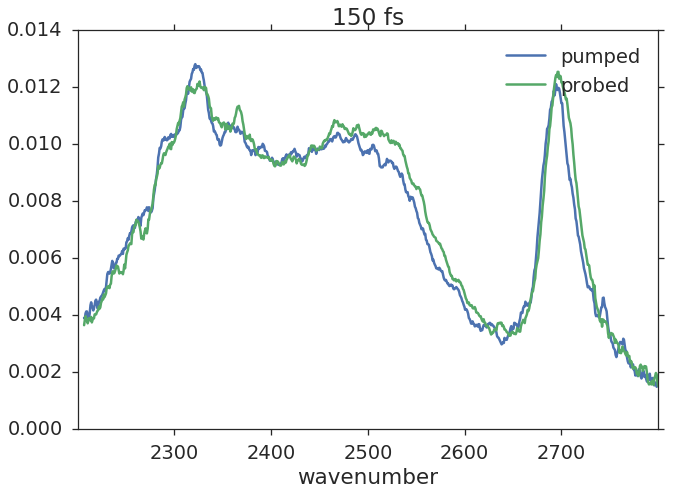

In [10]:
#pp_slider3 = ipyw.SelectionSlider(options=list(ppdData.ts0.pp_delays), value=0, continuous_update=False)
roi = slice(2200,2800) # get this from the pump
def p3(pp_delay):
    ppdData.ts0.pumped.loc[pp_delay][roi].rolling(10).mean().plot(label="pumped")
    ppdData.ts0.probed.loc[pp_delay][roi].rolling(10).mean().plot(label="probed")
    #plt.ylim(0.001, 0.015)
    plt.title(str(pp_delay) + " fs")
    plt.legend()
    #plt.grid()

ppWidget.p3 = ipyw.interactive(p3, pp_delay=ppWidget.ts0_ppdelay_childs[2])
display(ppWidget.p3)
plt.show()

# Bleach Trace

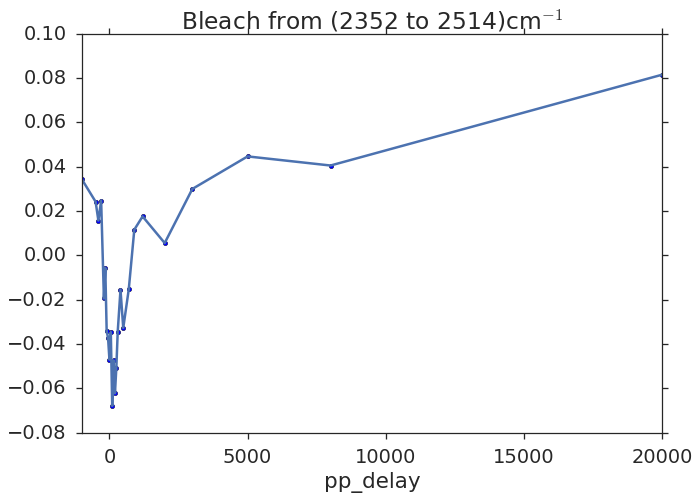

In [11]:
roi_slider_range = int(ppdData.ts0.df.index.levels[1].min()), int(ppdData.ts0.df.index.levels[1].max())
#roi_slider_range = 0, 800
roi_slider = ipyw.IntRangeSlider(
    value = (2450, 2600),
    min = roi_slider_range[0],
    max = roi_slider_range[1],
    continuous_update=False
)

#roi = slice(2450,2600)

def plot_bleach_trace(roi):
    tss = ppdData.ts0.bleach.unstack(0)
    tss = tss[(tss.index > roi[0]) & (tss.index < roi[1])].sum()

    tss.plot()
    plt.scatter(tss.index, tss)
    plt.title(r"Bleach from (%i to %i)cm$^{-1}$"%(roi[0], roi[1]))
    
ipyw.interact(plot_bleach_trace, roi=roi_slider)
plt.show()

In [16]:
ppdData.ts0.pump

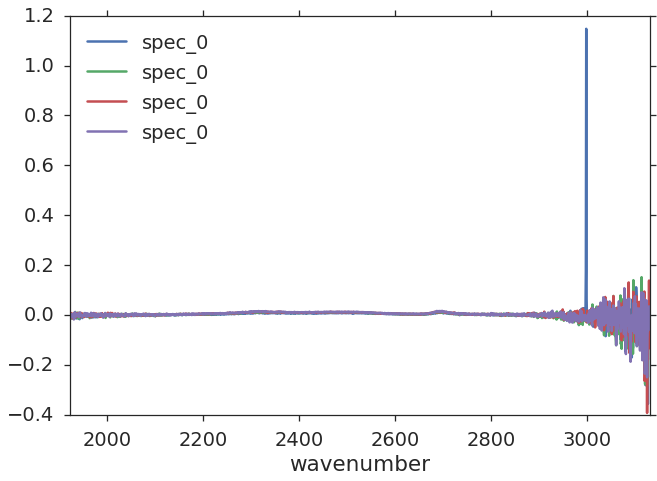

In [15]:
ppdData.ts0.df.ix[0, "spec_0"].plot()